Load needed libraries

In [ ]:
from google.colab import drive, files
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install opencv-contrib-python==4.4.0.44

     |████████████████████████████████| 55.7 MB 1.3 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from sklearn.cluster import MeanShift, estimate_bandwidth
from shapely.geometry import box,mapping
from scipy.interpolate import interp1d
from skimage.feature import peak_local_max
import scipy.ndimage.filters as filters
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

STEP B: 
Test on scene image: {m1.png, m2.png, m3.png, m4.png, m5.png}  

Use product images: {0.jpg, 1.jpg, 11.jpg, 19.jpg, 24.jpg, 26.jpg, 25.jpg}

In [ ]:
scene_paths = ["m1.png","m2.png","m3.png","m4.png","m5.png"]
model_paths = ["0.jpg","1.jpg","11.jpg","19.jpg","24.jpg","26.jpg","25.jpg"]


def load_images(paths,dir):
  return [cv2.cvtColor(cv2.imread("/content/gdrive/My Drive/CV Project/"+dir+path),cv2.COLOR_BGR2RGB) for path in paths]
  
# Load scene and model images
train_images = load_images(scene_paths,"scenes/")
query_images = load_images(model_paths,"models/")

# Compute keypoints and descriptors
sift = cv2.SIFT_create()

train_features = {index:sift.detectAndCompute(train_image,None) for index,train_image in enumerate(train_images)}
query_features = {index:sift.detectAndCompute(query_image,None) for index,query_image in enumerate(query_images)}

In [ ]:
def compute_matches(FLANN_INDEX_KDTREE,trees,checks,k,lowe,des_train,des_query):
  index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = trees)
  search_params = dict(checks = checks)
  flann = cv2.FlannBasedMatcher(index_params, search_params)
  matches = flann.knnMatch(des_query,des_train,k=2)
  # store all the good matches as per Lowe's ratio test.
  good = []
  for m,n in matches:
      if m.distance < lowe*n.distance:
          good.append(m)
  return good

# Get the dominant color in the image with Kmeans clustering
def get_dom_color(img_in):
  Z = img_in.reshape((-1,3))
  Z = np.float32(Z)
  # define criteria, number of clusters(K) and apply kmeans()
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
  K = 1
  ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
  # Now convert back into uint8, and make original image
  center = np.uint8(center)
  res = center[label.flatten()]
  res2 = res.reshape((img_in.shape))
  return res2[0][0]

def get_roi(x1,x2,x3,x4,y1,y2,y3,y4,img):
  top_left_x = int(max(0,min([x1,x2,x3,x4])))
  top_left_y = int(max(0, min([y1,y2,y3,y4])))
  bot_right_x = int(max([x1,x2,x3,x4]))
  bot_right_y = int(max([y1,y2,y3,y4]))
  return (img[top_left_y:bot_right_y, top_left_x:bot_right_x],(top_left_x,top_left_y),(bot_right_x,bot_right_y))

def cluster_kp(keypoints, quantile = 0.10):
      x = np.array([keypoint.pt[0] for keypoint in keypoints]).reshape(-1,1) 
      bandwidth = estimate_bandwidth(x, quantile= quantile)
      ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=True)
      ms.fit(x)
      return ms.labels_, len(np.unique(ms.labels_))

def bb_intersection_over_union(rectangleA, rectangleB):
      intersection = rectangleA.intersection(rectangleB).area
      union = rectangleA.union(rectangleB).area
      if intersection and union:
        return intersection / union
      else:
        return 0

def non_maxima_suppression(rectangles, IOU_THRES = 0.15, MIN_DIAG = 80, MAX_DIAG = 700):
  x_dims = np.array([end[0] - start[0] for start,end in rectangles])
  y_dims = np.array([end[1] - start[1] for start,end in rectangles])
  filtered_rectangles = []
  for index in range(len(rectangles)):
    if x_dims[index] >= 300 and x_dims[index] <= 400:
      if y_dims[index] >= 300 and y_dims[index] <= 500:
        filtered_rectangles.append(rectangles[index])
  rectangles = filtered_rectangles
  if len(rectangles):
    polygons = [box(start[0], start[1], end[0],end[1]) for start,end in rectangles]
    maxima = []
    polygons.sort(key=lambda x: x.area, reverse=True)
    for index,poly in enumerate(polygons):
      found = False
      for poly_2 in maxima:
        if bb_intersection_over_union(poly,poly_2) >= IOU_THRES or bb_intersection_over_union(poly_2,poly) >= IOU_THRES:
          found = True
      if not found:
         maxima.append(poly)
    return maxima
  else:
     return []


def compute_feature_vector(query_kp,train_kp,train_shape,N_HORIZONTAL_BINS = 15,N_VERTICAL_BINS = 10):
  query_xy = np.array([kp.pt for kp in query_kp])
  train_xy = np.array([kp.pt for kp in train_kp])
  N_HORIZONTAL_BINS = train_shape[1] // 100
  N_VERTICAL_BINS = train_shape[0] // 120
  # Baricenter of matched query keypoints 
  bary_x,bary_y = query_xy.mean(axis = 0)
  scale_ratio = np.array([kp_t.size / kp_q.size for kp_t,kp_q in zip(train_kp,query_kp)])
  angle_diff = np.array([kp_t.angle - kp_q.angle for kp_t,kp_q in zip(train_kp,query_kp)])
  Vx_i = np.array(query_xy[:,0] - bary_x)
  Vy_i = np.array(query_xy[:,1] - bary_y)
  pred_bary_x = train_xy[:,0] + scale_ratio * (np.cos(angle_diff) * Vx_i - np.sin(angle_diff) * Vy_i)
  pred_bary_y = train_xy[:,1] + scale_ratio * (np.sin(angle_diff) * Vx_i - np.cos(angle_diff) * Vy_i)
  interp_x = interp1d([0,train_shape[1]],[0,N_HORIZONTAL_BINS])
  interp_y = interp1d([0,train_shape[0]],[0,N_VERTICAL_BINS])
  votes_x = [int(interp_x(pred_x)) if pred_x >= 0 and pred_x <= train_shape[1] else -1 for pred_x in pred_bary_x]
  votes_y = [int(interp_y(pred_y)) if pred_y >= 0 and pred_y <= train_shape[0] else -1 for pred_y in pred_bary_y]
  votes = {}
  votes_matrix = np.zeros((N_VERTICAL_BINS,N_HORIZONTAL_BINS))
  for index,(votes_x,votes_y) in enumerate(zip(votes_x,votes_y)):
    if votes_x >= 0 and votes_y >= 0:
      votes.setdefault((votes_y,votes_x),[]).append((train_kp[index],query_kp[index]))
      votes_matrix[votes_y,votes_x] += 1
  return (votes,votes_matrix)



def grab_neigh_indexes(max_index):
  neigh_indexes = []
  for i in range(-1,2):
    for j in range(-2,3):
      neigh_indexes.append((max_index[0] + i,max_index[1] + j))
  return neigh_indexes

  # Print the output and draw the bounding box and centroids
def print_output(query_idx,rectangles,img_train):
    print("Product {} - {} Instances Found:".format(query_idx,len(rectangles)))
    for index in range(len(rectangles)):
        centroid = rectangles[index].centroid
        bounding_box = mapping(rectangles[index])["coordinates"]
        width = int(bounding_box[0][1][0]) - int(bounding_box[0][3][0])
        height = int(bounding_box[0][1][1]) - int(bounding_box[0][3][1])
        cv2.rectangle(img_train, (int(bounding_box[0][3][0]),int(bounding_box[0][3][1])), (int(bounding_box[0][1][0]),int(bounding_box[0][1][1])), (0,255,0), thickness = 5)
        cv2.circle(img_train, (int(centroid.xy[0][0]),int(centroid.xy[1][0])), radius=5, color=(0, 255, 0), thickness=-1)
        print("Instance {} [ position: (({},{}), width: {} px, height: {} px]".format(query_idx,centroid.xy[0][0],centroid.xy[1][0],width,height))

    return len(rectangles)

Product 4 - 2 Instances Found:
Instance 4 [ position: ((184.0,232.5), width: 364 px, height: 465 px]
Instance 4 [ position: ((549.0,232.5), width: 340 px, height: 465 px]
Product 5 - 1 Instances Found:
Instance 5 [ position: ((922.0,231.5), width: 338 px, height: 463 px]
Product 6 - 1 Instances Found:
Instance 6 [ position: ((1259.0,231.0), width: 322 px, height: 450 px]


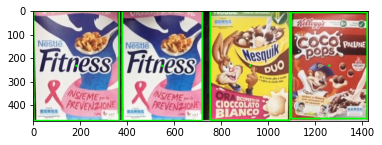

Product 0 - 1 Instances Found:
Instance 0 [ position: ((178.0,303.5), width: 348 px, height: 461 px]
Product 1 - 2 Instances Found:
Instance 1 [ position: ((847.5,262.0), width: 319 px, height: 414 px]
Instance 1 [ position: ((1181.5,254.5), width: 307 px, height: 419 px]
Product 2 - 1 Instances Found:
Instance 2 [ position: ((513.0,251.0), width: 312 px, height: 406 px]
No Homography was found
No Homography was found


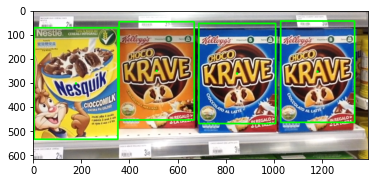

No Homography was found
No Homography was found
Product 3 - 1 Instances Found:
Instance 3 [ position: ((1233.0,190.5), width: 302 px, height: 381 px]
Product 5 - 1 Instances Found:
Instance 5 [ position: ((192.0,230.0), width: 364 px, height: 460 px]
Product 6 - 2 Instances Found:
Instance 6 [ position: ((558.0,228.5), width: 340 px, height: 457 px]
Instance 6 [ position: ((888.5,226.0), width: 329 px, height: 446 px]


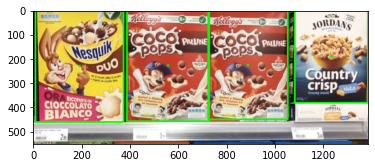

No Homography was found
No Homography was found
Product 4 - 2 Instances Found:
Instance 4 [ position: ((540.0,224.5), width: 360 px, height: 449 px]
Instance 4 [ position: ((176.0,224.5), width: 352 px, height: 449 px]
Product 5 - 1 Instances Found:
Instance 5 [ position: ((920.0,222.0), width: 344 px, height: 444 px]
Product 6 - 2 Instances Found:
Instance 6 [ position: ((1269.5,217.0), width: 331 px, height: 434 px]
Instance 6 [ position: ((1585.0,218.0), width: 318 px, height: 436 px]


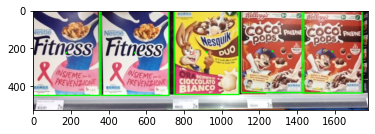

Product 1 - 2 Instances Found:
Instance 1 [ position: ((500.5,724.0), width: 319 px, height: 416 px]
Instance 1 [ position: ((829.5,714.0), width: 305 px, height: 434 px]
Product 2 - 1 Instances Found:
Instance 2 [ position: ((167.5,716.0), width: 313 px, height: 408 px]
Product 3 - 1 Instances Found:
Instance 3 [ position: ((908.0,191.0), width: 300 px, height: 382 px]
Product 6 - 2 Instances Found:
Instance 6 [ position: ((229.5,248.0), width: 357 px, height: 496 px]
Instance 6 [ position: ((563.0,230.5), width: 332 px, height: 457 px]


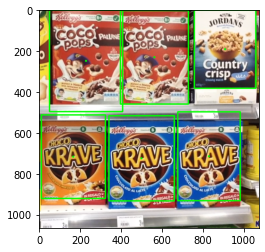

True


In [ ]:
def object_retrieve(query_idx,img_query, img_train, query_features, train_features, min_match_count = 0, COLOR_DIFF_THRESHOLD = 55, verbose = False):
    rectangles = []
    key_train,des_train = np.array(train_features[0]),np.array(train_features[1])
    key_query,des_query = np.array(query_features[0]),np.array(query_features[1])
    good = compute_matches(0,5,50,2,0.70,des_train,des_query)
    # If it's a good match, then proceed with the detection
    if len(good)>min_match_count:
       query_pts = np.array([key_query[m.queryIdx] for m in good ])
       train_pts = np.array([key_train[m.trainIdx] for m in good ])
       # Fetch votes dictionary and accumulator votes matrix
       votes,votes_matrix = compute_feature_vector(query_pts,train_pts, img_train.shape)
       # Get local maxima in the accumulator matrix
       data_max = filters.maximum_filter(votes_matrix, (2,4))
       indexes = np.where(data_max == votes_matrix, votes_matrix, 0)
       indexes = [(row[0],row[1])for row in np.argwhere(indexes > 0)]
       for index in indexes:
        if votes_matrix[index] >= 2:
          neigh_indexes = grab_neigh_indexes(index)
          neigh_votes = [vote for index in neigh_indexes for vote in votes.get(index,[])]
          src_points = np.float32([vote[1].pt for vote in neigh_votes]).reshape(-1,1,2)
          dst_points = np.float32([vote[0].pt for vote in neigh_votes]).reshape(-1,1,2)
          if len(src_points) >= 4:
            M, mask = cv2.findHomography(src_points, dst_points, cv2.RANSAC, 2.0)
            if M is None:
                print ("No Homography was found")
            else:
                h,w,_ = img_query.shape
                # Generate and plot the rectangle into the target image
                pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
                dst = cv2.perspectiveTransform(pts,M)
                roi,start,end = get_roi(dst[0][0][0],dst[1][0][0],dst[2][0][0],dst[3][0][0],dst[0][0][1],dst[1][0][1],dst[2][0][1],dst[3][0][1],img_train)
                # If we can manage to obtain a rectangle, then we proceed
                if len(roi):
                  color_diff = np.linalg.norm(roi.mean(axis = 0).mean(axis = 0) - img_query.mean(axis = 0).mean(axis = 0))
                  if color_diff <= COLOR_DIFF_THRESHOLD:
                    
                    rectangles.append((start,end))
                    # check if the euclidean distance between the colors (mean) of the two rectangle is lower than the chosen threshold

    rectangles = non_maxima_suppression(np.array(rectangles))

      # Draw the bounding box and center pixel of every blob
    if len(rectangles):
      print_output(query_idx,rectangles,img_train)

    return len(rectangles)


pred_labels = {}
#Iterating among all scenes and looking for the query object.
for index_train in range(0,5):
  scene_labels = []
  dump = train_images[index_train].copy()
  for index_query in range(len(query_images)):
    scene_labels.append(object_retrieve(index_query,query_images[index_query], train_images[index_train], query_features[index_query], train_features[index_train]))
  imgplot = plt.imshow(train_images[index_train])
  plt.show()
  pred_labels[index_train] = scene_labels
  train_images[index_train] = dump

true_labels = {
    0: [0,0,0,0,2,1,1],
    1: [1,2,1,0,0,0,0],
    2: [0,0,0,1,0,1,2],
    3: [0,0,0,0,2,1,2],
    4: [0,2,1,1,0,0,2],
}
print(true_labels == pred_labels)